In this notebook, we explore the application of multi-step stacked and Vanilla LSTM models for forecasting Tesla stock prices. The objective is to predict key stock metrics such as Open, High, Low, Close, and Volume. Using historical stock data, we implement and evaluate the performance of these models, with a focus on RMSE (Root Mean Squared Error) for Open and Close prices. The models are trained on a multi-step forecasting approach, providing insights into stock price trends with a high degree of accuracy. We present the results, highlighting the RMSE values achieved for the Open/Close prices, which were 4.16/7.48, demonstrating the models' forecasting capabilities. Additionally, various visualization techniques such as line plots and error distribution graphs are used to analyze the predictions and model performance, offering a clearer understanding of the forecasting results and the overall model accuracy.



In [1]:

import kagglehub
rpaguirre_tesla_stock_price_path = kagglehub.dataset_download('rpaguirre/tesla-stock-price')
timoboz_tesla_stock_data_from_2010_to_2020_path = kagglehub.dataset_download('timoboz/tesla-stock-data-from-2010-to-2020')
varpit94_tesla_stock_data_updated_till_28jun2021_path = kagglehub.dataset_download('varpit94/tesla-stock-data-updated-till-28jun2021')
surajjha101_tesla_share_price_for_last_5_years_path = kagglehub.dataset_download('surajjha101/tesla-share-price-for-last-5-years')
guillemservera_tsla_stock_data_path = kagglehub.dataset_download('guillemservera/tsla-stock-data')

print('Data source import complete.')


100%|██████████| 33.7k/33.7k [00:00<00:00, 2.27MB/s]

Extracting files...


100%|██████████| 46.1k/46.1k [00:00<00:00, 1.53MB/s]

Extracting files...


100%|██████████| 58.6k/58.6k [00:00<00:00, 391kB/s]

Extracting files...


100%|██████████| 58.9k/58.9k [00:00<00:00, 394kB/s]

Extracting files...


100%|██████████| 220k/220k [00:00<00:00, 408kB/s]

Extracting files...
Data source import complete.


<a name='T'></a>

<div style="background-color: red; padding: 20px; border-radius: 5px; text-align: left; color: white; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
    <h1 style="font-size: 500%; margin-bottom: 25px;">Tesla Stock Forecasting</h1>
    <img src="https://images.pixexid.com/unleash-the-power-of-technology-with-a-2023-tesla-model-s-plaid-speeding-throug-bxx0b5la.jpeg" style="width: 50%; margin: 0 auto; display: block; border-radius: 100px 10px; box-shadow: 5px 5px 30px #333;  margin-bottom: 0px;">
    <h1 style="font-size: 500%; text-align: right"> Using LSTM</h1>
</div>


#### Overview

This  repository offers a full project dedicated to forecasting Tesla (TSLA) stock prices using deep learning techniques. It features both a single-step LSTM model for short-term predictions and a multi-stacked LSTM model designed to forecast stock trends across multiple future business days (approximately one month). Alongside practical implementations, the project also delves into the theoretical and mathematical foundations of LSTM networks, providing a thorough understanding of their inner workings. By exploring the provided code and datasets, users can deepen their knowledge of LSTM behavior, multi-layered architectures, and multistep forecasting for financial time series.

## &#8711; <span style='color:red'>|</span> Table of Contents
1. [`Introduction`](#I)
2. [`Tesla Data`](#D)
3. [`Imports & Setup`](#is)
    * 3.1 [`Tesla Data`](#tsladata)
4. [`Data Visualization`](#DV)
    * 4.1 [`Candlestick Plots`](#DV)
    * 4.2 [`Stock Splits`](#splits)
    * 4.3 [`Percentage Change in Stock`](#pchange)
5. [`Single Step LSTM`](#lstm)
    * 5.1 [`Data Prep`](#lstm)
    * 5.2 [`Model Building`](#buildmodel)
    * 5.3 [`Predictions`](#pred)
6. [`Multi-Step Stacked LSTM`](#mlstm)
    * 6.1 [`Multi-Step Math Background`](#mlstm)
    * 6.2 [`Stacked LSTM Background`](#background)
    * 6.3 [`Multi-Step Data Prep`](#mutlidataprep)
    * 6.4 [`Buidling Stacked LSTM`](#buildmlstm)
    * 6.5 [`Forecasting Multi-Step Stacked LSTM`](#forecast)
7. [`Bottom`](#B)



<a name='I'></a>

# <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -20px;">1| Introduction </p>

In this notebook, we delve into the use of Long Short-Term Memory (LSTM) networks—a specialized variant of Recurrent Neural Networks (RNNs)—to predict Tesla’s stock prices.

LSTM networks are uniquely structured to capture long-term dependencies within sequential data, making them highly effective for time-series tasks such as stock market prediction or natural language understanding. Unlike traditional feedforward neural networks, which process data points independently, LSTMs maintain a memory of past inputs through feedback connections. This enables them to consider historical sequences, an essential feature when forecasting stock prices where past trends heavily influence future behavior.

---

### <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -10px;">1.1.1| Intuitive Understanding of LSTM </p>

An LSTM unit is purpose-built to remember information across long sequences. It accomplishes this through three critical gates that regulate how information flows into, within, and out of the memory cell:

- **Forget Gate ($f_t$)**: Evaluates which parts of the previous memory ($C_{t-1}$) are no longer important and should be discarded. It uses the previous hidden state ($h_{t-1}$) and current input ($x_t$) to generate outputs between 0 and 1 via a sigmoid activation, where 1 means "retain completely" and 0 means "forget entirely."

- **Input Gate ($i_t$)**: Determines which new information should be added to the memory. It first generates an update decision using a sigmoid layer and then creates a candidate vector of potential values, $\tilde{C_t}$, through a `tanh` activation.

- **Cell State ($C_t$)**: Acts as the core memory. It gets updated by forgetting parts of the previous state and integrating new, relevant candidate values, thus carrying forward essential information through time.

- **Output Gate ($o_t$)**: Dictates the next hidden state ($h_t$) by filtering the updated cell state through a `tanh` activation and then modulating it using another sigmoid gate output.

<center>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width="60%" height="30%">
</center>

---

### <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -10px;">1.1.2| Mathematical Formulation of LSTM </p>

At each time step `t`, the LSTM cell performs a series of computations:

- **Forget Gate**:  
  $$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$  
  Controls which parts of the previous memory to retain.

- **Input Gate**:  
  $$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$  
  Determines the elements to update in the memory.

- **Candidate Memory Content**:  
  $$\tilde{C_t} = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$  
  Generates new candidate values to potentially add to the memory.

- **Update Cell State**:  
  $$C_t = f_t * C_{t-1} + i_t * \tilde{C_t}$$  
  Integrates forgotten and newly selected information.

- **Output Gate**:  
  $$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$  
  Decides what information from the memory becomes the output.

- **Hidden State**:  
  $$h_t = o_t * \tanh(C_t)$$  
  Produces the final output at the current time step.

Each weight ($W$) and bias ($b$) parameter in these equations is learned during model training. The controlled memory flow enables LSTMs to maintain relevant historical information over long sequences, a property crucial for modeling dependencies in stock price movements.

In the next sections, we will begin our journey by examining the Tesla stock dataset, featuring historical trading data such as open, high, low, close prices, trading volume, dividends, and stock splits.

---

<a name='D'></a>

# <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -20px;">2| Tesla Stock Dataset Overview </p>

This project utilizes historical stock market data for Tesla, Inc. (TSLA)—a company synonymous with innovation in the fields of electric vehicles, battery storage, and clean energy solutions. Tesla’s performance on the stock market garners substantial attention due to its technological leadership and dynamic market movements. Our dataset captures Tesla’s trading activities on a day-to-day basis through several crucial features:

- **`open`**: The price at which Tesla's stock commenced trading on a given day.

- **`high`**: The maximum trading price recorded during that day.

- **`low`**: The minimum price point Tesla's stock hit within the day.

- **`close`**: The final trading price of the day, widely regarded as the key reference point in financial reporting.

- **`volume`**: Represents the total number of shares traded during the day, reflecting the level of market interest and liquidity.

- **`dividends`**: Cash or stock payments made to shareholders, typically drawn from company profits.

- **`stock splits`**: Corporate actions that increase the number of outstanding shares while proportionally reducing the price per share to maintain the company's overall market capitalization. Splits often aim to improve stock affordability and liquidity without altering the intrinsic value.

Through detailed analysis of these metrics, we aim to model Tesla’s historical behavior and construct predictive models using LSTM-based architectures. By recognizing patterns and sequences in this data, our objective is to forecast future price movements with greater accuracy, enhancing financial decision-making processes.


<a name='is'>
    
# <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -20px;">3| Imports and Setup</p>

In [2]:
!pip install yfinance

In [3]:
# Data Imports
import yfinance as yf
import pandas as pd
import numpy as np
import random

from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.offsets import BDay

# Visualization Imports
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import scipy.stats as stats

# Neural Network Imports
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint

# Setting seed
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Visualization Configurations
pio.templates.default = "plotly_dark"
%config InlineBackend.figure_format = 'retina'

<a name='tsladata'>
    
## <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -10px;">3.1| Tesla Data </p>

In [4]:
def show(data: pd.DataFrame):
    df = data.copy()
    df = df.style.format(precision=3)
    df = df.background_gradient(cmap='Reds', axis=0)
    display(df)

def highlight_half(data: pd.DataFrame, axis=1, precision=3):

    s = data.shape[1] if axis else data.shape[0]
    data_style = data.style.format(precision=precision)

    def apply_style(val):
        style1 = 'background-color: red; color: white'
        style2 = 'background-color: blue; color: white'
        return [style1 if x < s//2 else style2 for x in range(s)]

    display(data_style.apply(apply_style, axis=axis))

In [5]:
# Target stock & columns for modeling
SYMBOL = "TSLA"
columns = ['open', 'high', 'low', 'close', 'volume']

# Getting Tesla (TSLA) stock data
ticker = yf.Ticker(SYMBOL)

# End stock dates
end_date = "2023-12-01"

# Pulling stock data
df = ticker.history(start="2017-01-01", end=end_date)
df.columns = df.columns.str.lower()

# Showing styled table
def style_table(df):
    return df.style.set_table_styles(
        [{'selector': 'thead th',
          'props': [('background-color', '#FF4C4C'),  # Red header
                    ('color', 'white'),
                    ('font-size', '110%'),
                    ('border-radius', '5px')]}]
    ).set_properties(
        **{'background-color': '#FFF5F5',  # Light pinkish background
           'color': 'black',
           'border-color': 'black',
           'font-size': '105%'}
    ).highlight_max(color='#FF9999').highlight_min(color='#FFCCCC')  # highlight max/min values

style_table(df.tail())


,open,high,low,close,volume,dividends,stock splits
Date,,,,,,,
2023-11-24 00:00:00-05:00,233.750000,238.750000,232.330002,235.449997,65125200,0.000000,0.000000
2023-11-27 00:00:00-05:00,236.889999,238.330002,232.100006,236.080002,112031800,0.000000,0.000000
2023-11-28 00:00:00-05:00,236.679993,247.000000,234.009995,246.720001,148549900,0.000000,0.000000
2023-11-29 00:00:00-05:00,249.210007,252.750000,242.759995,244.139999,135401300,0.000000,0.000000
2023-11-30 00:00:00-05:00,245.139999,245.220001,236.910004,240.080002,132353200,0.000000,0.000000


In [6]:
# Data info
print('Data Info:')
df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1740 entries, 2017-01-03 00:00:00-05:00 to 2023-11-30 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          1740 non-null   float64
 1   high          1740 non-null   float64
 2   low           1740 non-null   float64
 3   close         1740 non-null   float64
 4   volume        1740 non-null   int64  
 5   dividends     1740 non-null   float64
 6   stock splits  1740 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 108.8 KB


<a name='DV'>
    
# <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -65px;">4| Data Visualization </p>
## <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -10px;">4.1| Candle Stick Plots  </p>
    

Candlestick charts are a visual tool for market analysis, used to describe price movements of a security, derivative, or currency. Each "candlestick" typically represents one day of trading and is composed of a body and wicks.
- **Body**: The wider section of the candlestick which indicates the opening and closing prices. If the body is filled or dark, the security closed lower than it opened. If the body is empty or light, it closed higher than it opened.
- **Wicks**: Lines that extend from the top and bottom of the body representing the high and low prices during the period.


In [7]:
import plotly.graph_objects as go

def plot_candlestick(stock_df, name='Tesla', rolling_avg=None, fig_size=(1100, 700)):
    """
    Plot an enhanced candlestick chart with optional rolling averages.

    Args:
        stock_df (pd.DataFrame): The stock data.
        name (str): Name of the stock.
        rolling_avg (list, optional): List of window sizes for rolling averages.
        fig_size (tuple): Size of the figure.
    """
    stock_data = stock_df.copy()

    fig = go.Figure()

    # Candlestick
    fig.add_trace(go.Candlestick(
        x=stock_data.index,
        open=stock_data['open'],
        high=stock_data['high'],
        low=stock_data['low'],
        close=stock_data['close'],
        name="Price",
        increasing_line_color='limegreen',  # brighter green
        decreasing_line_color='tomato',     # softer red
        increasing_fillcolor='rgba(0,255,0,0.3)',  # greenish fill
        decreasing_fillcolor='rgba(255,0,0,0.3)',  # reddish fill
        line_width=1.2
    ))

    # Rolling Averages
    if rolling_avg:
        palette = ['#00CED1', '#FFD700', '#FF7F50', '#FF69B4', '#8B4513', '#708090', '#9ACD32', '#4169E1']

        for i, avg in enumerate(rolling_avg):
            color = palette[i % len(palette)]
            ma_column = f'{avg}-day MA'
            stock_data[ma_column] = stock_data['close'].rolling(window=avg).mean()
            fig.add_trace(go.Scatter(
                x=stock_data.index,
                y=stock_data[ma_column],
                mode='lines',
                name=f'{avg}-Day MA',
                line=dict(color=color, width=2, dash='solid')
            ))

    # Layout
    fig.update_layout(
        title=dict(
            text=f"{name} Stock Price - Candlestick Chart",
            x=0.5,
            font=dict(color='darkblue', size=24, family="Arial Black")
        ),
        width=fig_size[0], height=fig_size[1],
        plot_bgcolor='whitesmoke',
        paper_bgcolor='lavender',
        xaxis_title='Date',
        yaxis_title='Stock Price (USD)',
        font=dict(color='black', size=14),
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=14, label="2w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(count=2, label="2y", step="year", stepmode="backward"),
                    dict(count=5, label="5y", step="year", stepmode="backward"),
                    dict(step="all", label="All")
                ]),
                bgcolor='lightyellow',
                font=dict(color='darkblue', size=12),
                activecolor='limegreen'
            ),
            rangeslider=dict(visible=True, thickness=0.05, bgcolor="lightgray")
        ),
        yaxis=dict(
            gridcolor='lightgray',
            zerolinecolor='gray'
        ),
        hovermode="x unified",
    )

    fig.show()


In [8]:
# General Tesla stocks
plot_candlestick(df, name=SYMBOL)

# With Moving averages
plot_candlestick(df, name=SYMBOL, rolling_avg=[20, 50, 200])

<a name='splits'>
    
## <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -10px;">4.2| Tesla Stock Splits  </p>

In [9]:
# Plotting stock splits
fig = px.line(x=df.index, y=df['stock splits'], title=f'{SYMBOL} Stock Splits Over Time')
fig.update_layout(width=1100, height=500)
fig.update_traces(line=dict(color='cyan', width=3))
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Stock Splits')
fig.show()

<a name='pchange'>

## <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -20px;">4.3| Percent Change in Stock Prices </p>
    
The percentage change in stock prices is a measure used to express the change in price over time as a proportion of the previous price. This metric is useful for comparing the performance of a stock across different time frames or against other stocks. The formula to calculate the daily percentage change is:
$$\text{Percentage Change} = \left( \frac{\text{Current Price} - \text{Previous Price}}{\text{Previous Price}} \right) \times 100
$$
- **Current Price** is the price of the stock at the end of the current period (e.g., end of the day).
- **Previous Price** is the price of the stock at the end of the previous period.

For the first period in a time series data set (e.g., the first day of available stock data), the percentage change is not defined as there is no previous price to compare to. In such cases, it is common to set the percentage change to zero or to omit the value. When analyzing stock data over a longer period, such as a month or year, the percentage change is calculated using the price at the beginning and the end of the period. This metric is commonly used in financial analysis to assess the volatility and performance of stocks. It is also a key indicator for investors making decisions about buying or selling securities.


In [10]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Creating subplot
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.7, 0.3],
    vertical_spacing=0.12, horizontal_spacing=0.08,
    subplot_titles=(f"{SYMBOL} - Percent Change Over Time",
                    f"{SYMBOL} - Percent Change Histogram",
                    f"{SYMBOL} - Volume Over Time",
                    f"{SYMBOL} - Volume Histogram")
)

# Calculating Percent Change
percent_change = df['close'].pct_change() * 100

# Plotting Percent Change Line and Histogram
fig.add_trace(
    go.Scatter(
        x=df.index, y=percent_change,
        mode='lines',
        name='Percent Change',
        line=dict(color='mediumvioletred')
    ),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(
        x=percent_change, nbinsx=50,
        name='Percent Change Distribution',
        marker_color='mediumvioletred',
        opacity=0.7
    ),
    row=1, col=2
)

# Annotations for Percent Change
fig.add_annotation(
    text=f"<b>Mean:</b> {percent_change.mean():.2f}%<br><b>Std Dev:</b> {percent_change.std():.2f}%",
    xref='paper', yref='paper',
    x=0.95, y=0.85, showarrow=False,
    font=dict(size=12, color="black"),
    bgcolor="lightpink", bordercolor="black", borderwidth=1
)

# Plotting Volume Line and Histogram
fig.add_trace(
    go.Scatter(
        x=df.index, y=df['volume'],
        mode='lines',
        name='Volume',
        line=dict(color='teal')
    ),
    row=2, col=1
)

fig.add_trace(
    go.Histogram(
        x=df['volume'], nbinsx=50,
        name='Volume Distribution',
        marker_color='teal',
        opacity=0.7
    ),
    row=2, col=2
)

# Annotations for Volume
fig.add_annotation(
    text=f"<b>Mean:</b> {df['volume'].mean():.2f}<br><b>Std Dev:</b> {df['volume'].std():.2f}",
    xref='paper', yref='paper',
    x=0.95, y=0.35, showarrow=False,
    font=dict(size=12, color="black"),
    bgcolor="lightcyan", bordercolor="black", borderwidth=1
)

# Updating layout
fig.update_layout(
    height=750, width=1200,
    title_text=f"{SYMBOL} Stock Analysis",
    title_x=0.5,
    template='plotly_white',
    plot_bgcolor='white',
    paper_bgcolor='whitesmoke',
    font=dict(family="Arial", size=13, color="black"),
    showlegend=False
)

# Updating axes
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgrey')

fig.show()


- **Tesla Percent Change over Time:** plot displays the daily percentage change of Tesla's stock price, revealing the volatility over the observed period. The fluctuations are captured by sharp spikes and dips, indicating days with significant price movements. This could be reflective of market reactions to news events, earnings reports, or broader economic conditions.

- **Tesla Percent Change - Histogram:** plot on the top right presents the distribution of these daily percentage changes. Most changes cluster around the mean, suggesting a normal distribution of returns, which is typical for stock prices over time. The mean close to zero implies stable average growth, while the standard deviation indicates the extent of variation from the average.

- **Tesla Stock Volume over Time:** showing the traded volume of Tesla's stock. Peaks in this plot could correspond to specific events or the release of significant news affecting investor sentiment and trading behavior.

- **Tesla Stock Volume - Histogram:** illustrates the distribution of trading volume, indicating how often certain volumes occur. The mean and standard deviation provide a summary of the typical volume and its variability. The concentration of data on the lower end suggests that high-volume days are less frequent but can be associated with key market or company-specific events.

<a name='lstm'>
    
# <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -65px;">5| LSTM </p>
## <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -30px;">5.1| LSTM Data Prep </p>

In machine learning, it's often crucial, especialy when using neural networks, to normalize data before feeding it into a model. This process adjusts values measured on different scales to a notionally common scale, often prior to averaging. Here, we use the `MinMaxScaler` from the `sklearn.preprocessing` package, which scales each feature by its maximum and minimum values. This scaler transforms each value `v` in a feature column to `v'` in the range [0, 1] using the following formula:
$$v' = \frac{v - \text{min}(v)}{\text{max}(v) - \text{min}(v)}$$
- `v` is the original value.
- `min(v)` is the minimum value in the feature column.
- `max(v)` is the maximum value in the feature column.
The columns `['open', 'high', 'low', 'close', 'volume']` from the Tesla stock dataset are normalized, which includes the opening, high, low, and closing prices along with the trading volume. Normalizing these features allows for a more stable and faster convergence during the training of neural networks, like the LSTM model we'll be using for stock price forecasting.


In [11]:
class RNNFormater:

    def __init__(self, data: pd.DataFrame, mapping_steps=10):
        """
        Initialize the RNNFormater with a DataFrame and steps to map for data.

        Args:
            data (pd.DataFrame): Input DataFrame containing time series data.
            mapping_steps (int): Number of time steps for each input sequence to be mapped to output.
        """
        # Storing data
        self.df = data.copy()
        self.data = self.df.values

        # Scaler stored for usage later
        self.scaler = MinMaxScaler()
        self.normalized_data = self.scaler.fit_transform(self.data)

        self.time_steps = data.shape[0]
        self.n_columns = data.shape[1]

        # Number of mapping steps
        self.mapping_steps = mapping_steps

    def data_mapping(self):
        """
        Maps a 2D array into a 3D array for RNNs input, with each sequence having mapping_steps time steps.

        Args:
            mapping_steps (int): Number of time steps for each sequence.

        Returns:
            np.array: A 3D array suitable for RNN inputs.
        """
        mapping_steps = self.mapping_steps + 1

        mapping_iterations = self.time_steps - mapping_steps + 1
        self.normalized_data_mapped = np.empty((mapping_iterations, mapping_steps, self.n_columns))

        for i in range(mapping_iterations):
            self.normalized_data_mapped[i, :, :] = self.normalized_data[i:i + mapping_steps, :]

        return self.normalized_data_mapped

    def rnn_train_test_split(self, test_percent=0.1):
        """
        Splits the 3D mapped data into training and testing sets for an RNN.

        Args:
            test_percent (float): The fraction of data to be used for testing.

        Returns:
            tuple: X_train, X_test, y_train, y_test
        """
        self.test_size = int(np.round(self.normalized_data_mapped.shape[0] * test_percent))
        self.train_size = self.normalized_data_mapped.shape[0] - self.test_size

        X_train = self.normalized_data_mapped[:self.train_size, :-1, :]
        y_train = self.normalized_data_mapped[:self.train_size, -1, :]

        X_test = self.normalized_data_mapped[self.train_size:, :-1, :]
        y_test = self.normalized_data_mapped[self.train_size:, -1, :]

        return X_train, X_test, y_train, y_test

    def forecast_n_steps(self, model, data: pd.DataFrame, n_forecast_steps=30):
        """
        Forecast multiple steps ahead using the LSTM model.

        Args:
            model (tf.keras.Model): Trained LSTM model for prediction.
            data (pd.DataFrame): Input DataFrame containing the latest time series data.
            n_forecast_steps (int): Number of future steps to forecast.

        Returns:
            np.array: Forecasted values for n_forecast_steps.
        """
        # Scaling the latest 'mapping_steps' data for mapping
        last_steps = self.scaler.transform(data.values)[-self.mapping_steps:]

        # Initialize normalized_data_mapped array
        normalized_data_mapped = np.empty((n_forecast_steps, self.mapping_steps, self.n_columns))

        # Initialize predictions array
        predictions = np.empty((n_forecast_steps, self.n_columns))

        # Predict the first step
        normalized_data_mapped[0, :, :] = last_steps
        predictions[0, :] = model.predict(
            normalized_data_mapped[0, :, :].reshape(1, self.mapping_steps, self.n_columns),
            verbose=False
        )
        # Generate predictions and update normalized_data_mapped for each subsequent step
        for i in range(1, n_forecast_steps):
            # Shift the window and insert new prediction at end
            normalized_data_mapped[i, :-1, :] = normalized_data_mapped[i - 1, 1:, :]
            normalized_data_mapped[i, -1, :] = predictions[i - 1, :]

            # Predicting next step
            norm_data = normalized_data_mapped[i, :, :].reshape(1, self.mapping_steps, self.n_columns)
            predictions[i, :] = model.predict(norm_data, verbose=False)

        # Inverse transform the predictions to original scale
        predictions = self.scaler.inverse_transform(predictions)
        return predictions


In [12]:
# Initializing class
mapping_steps = 32 # ~ 1 months in buisness days
rnn_formater = RNNFormater(df[columns], mapping_steps=mapping_steps)

# Mapping steps
norm_data_mapped = rnn_formater.data_mapping() # n_steps -> y
# print(f'Mapped Normalized data step 0:\n{norm_data_mapped[0]}')
print(f'Normalized data shape: {norm_data_mapped[0].shape}')

Normalized data shape: (33, 5)


In [13]:
# Train Test Split
X_train, X_test, y_train, y_test = rnn_formater.rnn_train_test_split(test_percent=0.05)
print(f'Number of time steps for test set: {rnn_formater.test_size}')

print(f'X shape: {X_train.shape}')
# print(X_train[0])

print(f'y shape: {y_train.shape}')
# print(y_train[0])

Number of time steps for test set: 85
X shape: (1623, 32, 5)
y shape: (1623, 5)


<a name='buildmodel'>

## <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -10px;">5.2| Vanilla LSTM Model Building </p>

In [14]:
# For consistant results
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Vanilla LSTM
model = models.Sequential([
    LSTM(units=80, input_shape=(mapping_steps, len(columns))),
    Dropout(0.05),
    Dense(units=len(columns))
])

# Compiling model
model.compile(optimizer='adam', loss='mae')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 80)             │        27,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,925 (109.08 KB)

 Trainable params: 27,925 (109.08 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
!pip install keras-tqdm


In [16]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tqdm.notebook import tqdm

# Custom callback for TQDM Epoch Progress Bar
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc='Training Progress', position=0)

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)
        self.progress_bar.set_postfix({
            'loss': logs.get('loss', 0),
            'val_loss': logs.get('val_loss', 0)
        })

    def on_train_end(self, logs=None):
        self.progress_bar.close()

# Save best model checkpoint
model_checkpoint = ModelCheckpoint(
    'LSTM_Tesla_best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

# Now fit the model with our custom TQDM progress
history = model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=1000,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint, TQDMProgressBar()],
    shuffle=False,
    verbose=0  # keep 0 because tqdm is handling progress
)

# Save final trained model
model.save('LSTM_Tesla_final_model.keras')


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
import numpy as np
import plotly.graph_objects as go

def plot_training_history(history, plot_title='Training Performance', plot_legends=None, color0=0):
    """
    Plots the training history of a model using Plotly with improved visuals.
    """
    # Extracting metrics
    epochs = np.arange(1, len(next(iter(history.values()))) + 1)
    colors = ['royalblue', 'orange', 'mediumvioletred', 'limegreen', 'crimson', 'teal', 'goldenrod']
    data = []

    # Use keys if no legends are provided
    if not plot_legends:
        plot_legends = list(history.keys())

    # Prepare each metric line
    for i, (key, legend) in enumerate(zip(history.keys(), plot_legends)):
        color_index = (i + color0) % len(colors)
        data.append(
            go.Scatter(
                x=epochs, y=history[key],
                mode='lines+markers',
                name=legend,
                line=dict(color=colors[color_index], width=2),
                marker=dict(symbol='circle', size=6)
            )
        )

    # Find minimum val_loss
    min_epoch = np.argmin(history['val_loss']) + 1
    loss_str = f"<b>Train Loss:</b> {history['loss'][min_epoch-1]:.3e}<br><b>Val Loss:</b> {history['val_loss'][min_epoch-1]:.3e}"

    # Creating layout
    layout = go.Layout(
        title=dict(text=plot_title, x=0.5),
        xaxis=dict(title='Epochs', showgrid=True, gridcolor='lightgrey'),
        yaxis=dict(title='Metric Value', showgrid=True, gridcolor='lightgrey'),
        plot_bgcolor='white',
        paper_bgcolor='whitesmoke',
        font=dict(family="Arial", size=13, color="black"),
        width=1100, height=600,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5)
    )

    # Create figure
    fig = go.Figure(data=data, layout=layout)

    # Add annotation
    fig.add_annotation(
        x=min_epoch,
        y=history['val_loss'][min_epoch - 1],
        text=loss_str,
        showarrow=True,
        arrowhead=3,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor='green',
        font=dict(size=12, color="black"),
        bgcolor="lightgreen",
        bordercolor="green",
        borderwidth=1,
        ax=0,
        ay=-80
    )

    fig.show()


In [18]:
# Plotting LSTM model loss
plot_training_history(history.history, plot_title='LSTM Model Loss')

In [25]:
# Loading best weights
model = models.load_model('LSTM_Tesla_best_model.keras')

# Predicting
predictions = model.predict(X_test, verbose=False)
predictions = rnn_formater.scaler.inverse_transform(predictions)

# Round predictions to 5 decimal places to prevent overflow
predictions_rounded = predictions.round(5)

# Preparing data
index_1 = y_test.shape[0]
df_y_test = df[columns].iloc[-index_1:]
df_predictions = pd.DataFrame(predictions_rounded, index=df_y_test.index, columns=[f'pred_{col}' for col in columns])
df_test_pred = pd.concat([df_y_test, df_predictions], axis=1)

# Round all values in df_test_pred to 5 decimal places
df_test_pred_rounded = df_test_pred.round(5)

import plotly.graph_objects as go

def display_predictions_table(df, title='Test vs Prediction Comparison'):
    # Set colors: real columns => darkgray, predicted columns => darkcyan
    cell_colors = []
    for col in df.columns:
        if 'pred' in col:
            cell_colors.append(['darkcyan'] * df.shape[0])
        else:
            cell_colors.append(['darkgray'] * df.shape[0])

    # Ensuring that only 5 decimal places are shown
    df_display = df.applymap(lambda x: f"{x:.5f}")

    fig = go.Figure(data=[go.Table(
        header=dict(
            values=[f"<b>{col}</b>" for col in df_display.columns],
            fill_color='black',  # Dark background
            font=dict(color='white', size=14),
            align='center'
        ),
        cells=dict(
            values=[df_display[col] for col in df_display.columns],
            fill_color=cell_colors,
            align='center',
            font=dict(size=12)
        )
    )])

    fig.update_layout(
        title={
            'text': title,
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        width=1200,
        height=500,
    )

    fig.show()

# Showing last few rows beautifully with rounded values
display_predictions_table(df_test_pred_rounded.tail(10))


<ipython-input-25-2856948f563e>:32: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



### <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red;">5.2.1| LSTM Resdiual Analysis Building </p>

In [26]:
# Error dataframe
df_error = pd.DataFrame(df_predictions.values - df_y_test.values, index=df.index[-index_1:], columns=[f'error_{col}' for col in columns])
print('RMSE Per Column')
print((df_error**2).mean()**(1/2))

RMSE Per Column
error_open      4.159390e+00
error_high      5.533110e+00
error_low       5.405035e+00
error_close     7.478043e+00
error_volume    1.706311e+07
dtype: float64


In [28]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import scipy.stats as stats

def plotly_residual_analysis(df, title_add=''):
    """
    Perform residual analysis for multiple features in a DataFrame.
    The DataFrame should contain actual and predicted columns for each feature.

    Args:
        df (pd.DataFrame): DataFrame containing actual and predicted columns.
        title_add (str, optional): Additional title for the subplots.
    """
    # Number of columns
    columns = [col for col in df.columns if not col.startswith('pred_')]
    num_features = len(columns)

    # Color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    # Subplots per columns
    fig = make_subplots(rows=num_features, cols=4, vertical_spacing=0.035, horizontal_spacing=0.035,
                        subplot_titles=("Histogram", "QQ-Normal Plot", "Residuals vs. Predicted Values", "Residuals vs Index"))

    for i, col in enumerate(columns):
        actual = df[col]
        predicted = df[f'pred_{col}']
        residuals = actual - predicted
        mean_residuals = np.mean(residuals)
        sd_residuals = np.std(residuals)
        rmse = np.sqrt(np.mean(residuals**2))
        index = df.index

        # Assign color for each feature
        color = colors[i % len(colors)]

        # Histogram of residuals
        fig.add_trace(go.Histogram(x=residuals, nbinsx=30, name=f'{col.title()} Residuals', marker_color=color, opacity=0.7), row=i+1, col=1)
        # Add lines for mean and standard deviation
        fig.add_vline(x=mean_residuals, line=dict(color='black', width=2), row=i+1, col=1)
        fig.add_vline(x=mean_residuals + sd_residuals, line=dict(color='grey', width=2, dash='dash'), row=i+1, col=1)
        fig.add_vline(x=mean_residuals - sd_residuals, line=dict(color='grey', width=2, dash='dash'), row=i+1, col=1)
        fig.add_annotation(x=mean_residuals, y=5, text=f"Mean: {mean_residuals:.2f}", showarrow=True, row=i+1, col=1)
        fig.add_annotation(x=sd_residuals + mean_residuals, y=5, text=f"SD: {sd_residuals:.2f}", showarrow=False, row=i+1, col=1)

        # QQ-Normal of residuals
        qq = stats.probplot(residuals, dist="norm", plot=None)
        fig.add_trace(go.Scatter(x=qq[0][0], y=qq[1][1] + qq[1][0]*qq[0][0], mode='lines',  showlegend=False, line=dict(color=color)), row=i+1, col=2)
        fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers', marker_color=color, name=f'{col.title()} QQ'), row=i+1, col=2)

        # Residuals vs. predicted values
        fig.add_trace(go.Scatter(x=predicted, y=residuals, mode='markers', marker_color=color, name=f'{col.title()} Resid Pred'), row=i+1, col=3)
        fig.add_hline(y=0, line=dict(color='darkred', width=2), row=i+1, col=3)
        fig.add_hline(y=2 * rmse, line=dict(color='darkred', dash='dash'), row=i+1, col=3)
        fig.add_hline(y=-2 * rmse, line=dict(color='darkred', dash='dash'), row=i+1, col=3)

        # Residuals vs. index
        fig.add_trace(go.Scatter(x=index, y=residuals, mode='markers', marker_color=color, name=f'{col.title()} Resid Index'), row=i+1, col=4)
        fig.add_hline(y=0, line=dict(color='darkred', width=2), row=i+1, col=4)
        fig.add_hline(y=2 * rmse, line=dict(color='darkred', dash='dash'), row=i+1, col=4)
        fig.add_hline(y=-2 * rmse, line=dict(color='darkred', dash='dash'), row=i+1, col=4)

    # Update layout
    fig.update_layout(height=250*num_features, width=1600, title_text="Residual Analysis " + title_add,
                      template='plotly_dark', showlegend=False)
    fig.show()


In [29]:
# Residual Analysis Plot
plotly_residual_analysis(df_test_pred,
                         title_add=f'- {SYMBOL} Vanilla LSTM')

<a name='pred'>

## <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -10px;">5.3| LSTM Predictions </p>

In [62]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def plot_predictions(y_values_df, predictions_df, title_add=''):
    """
    Plots actual values and predictions for each feature in separate subplots with enhanced visual style.

    Args:
        y_values_df (pd.DataFrame): DataFrame containing actual values.
        predictions_df (pd.DataFrame): DataFrame containing predicted values.
        title_add (str, optional): Additional title for the subplots.
    """
    # Number/color per feature
    columns = [col for col in y_values_df.columns]
    num_features = len(columns)
    actual_colors = ['cyan', 'lime', 'yellow', 'violet', 'gold', 'pink']

    # Creating subplots with updated spacing and font settings
    fig = make_subplots(rows=num_features, cols=1, vertical_spacing=0.05,
                        subplot_titles=[col.title() for col in columns])

    for i, col in enumerate(columns):
        # Actual values trace with markers and smoother lines
        fig.add_trace(go.Scatter(x=y_values_df.index, y=y_values_df[col], mode='lines+markers',
                                 name=col.title(), line=dict(color=actual_colors[i % len(actual_colors)], width=3),
                                 marker=dict(symbol='circle', size=6, color=actual_colors[i % len(actual_colors)])),
                      row=i+1, col=1)

        # Predicted values trace with dashed lines and markers
        pred_col = f'pred_{col}'
        if pred_col in predictions_df.columns:
            fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df[pred_col], mode='lines+markers',
                                     name=f'Predicted {col.title()}', line=dict(color='red', dash='dash', width=3),
                                     marker=dict(symbol='cross', size=6, color='red')),
                          row=i+1, col=1)

            # Calculate RMSE
            rmse = np.sqrt(np.mean((y_values_df[col] - predictions_df[pred_col]) ** 2))
            fig.add_annotation(xref='x domain', yref='y domain', x=1, y=0.15, showarrow=False,
                               text=f'RMSE: {rmse:.2f}', row=i+1, col=1,
                               font=dict(color='red', size=14, family="Arial, sans-serif"),
                               bgcolor='rgba(255, 255, 255, 0.7)', borderpad=4, opacity=0.8)

    # Updating the layout for a more polished appearance
    fig.update_layout(
        height=350 * num_features,
        width=1100,
        title_text="Data & Predictions " + title_add,
        title_font=dict(size=24, color='black', family="Arial, sans-serif"),
        plot_bgcolor='rgba(240, 240, 240, 0.9)',  # Light grey background
        paper_bgcolor='rgba(255, 255, 255, 1)',  # White paper background
        font=dict(family="Arial, sans-serif", size=12, color="black"),
        showlegend=True,
        margin=dict(l=40, r=40, t=80, b=40),  # Adjusting margins for better spacing
        xaxis=dict(showgrid=True, zeroline=True, gridcolor='rgba(204, 204, 204, 0.7)'),
        yaxis=dict(showgrid=True, zeroline=True, gridcolor='rgba(204, 204, 204, 0.7)'),
        hovermode="closest"  # Hover close to the points
    )

    # Display the plot
    fig.show()


In [63]:
# Plotting prediction and data
plot_predictions(df_y_test, df_predictions, title_add=f'- {SYMBOL} Vanilla LSTM')

### <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red;">5.3.1| Forecasting with LSTM Model </p>

In [65]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from pandas.tseries.offsets import BDay

# Assuming 'df' and 'mapping_steps' are already defined

# Getting last steps for LSTM forecast
last_steps = df[columns].iloc[-mapping_steps:, :]

# Number of steps to forecast
n_forecast_steps = 10  # ~ 2 weeks in business days

# Forming date index
date_index = pd.date_range(start=end_date, periods=n_forecast_steps, freq=BDay())

# Forecasting n-steps
forecast_array = rnn_formater.forecast_n_steps(model, last_steps, n_forecast_steps)

# Creating forecast DataFrame
forecast = pd.DataFrame(forecast_array, index=date_index, columns=[f'forecast_{col}' for col in columns])

# Styling the forecast DataFrame to highlight the values
forecast_styled = forecast.style.applymap(lambda x: 'background-color: lightgreen' if x > 0 else 'background-color: lightcoral')

# Display the styled DataFrame (in Jupyter Notebooks, it will display as styled table)
display(forecast_styled)

# Plotting the forecast vs actual values using Plotly for an interactive chart
fig = go.Figure()

# Actual data plot for each column
for col in columns:
    fig.add_trace(go.Scatter(x=df.index, y=df[col], mode='lines', name=f'Actual {col.title()}',
                             line=dict(color='blue', width=2)))

# Forecasted data plot for each column
for col in columns:
    fig.add_trace(go.Scatter(x=forecast.index, y=forecast[f'forecast_{col}'], mode='lines', name=f'Forecast {col.title()}',
                             line=dict(color='red', width=2, dash='dash')))

# Customize layout and make it visually appealing
fig.update_layout(
    title="Forecast vs Actual Values",
    title_font=dict(size=24, color='black', family="Arial, sans-serif"),
    xaxis=dict(title="Date", tickformat="%Y-%m-%d", title_font=dict(size=18, color='black'),
               tickangle=45),
    yaxis=dict(title="Value", title_font=dict(size=18, color='black')),
    plot_bgcolor='rgba(240, 240, 240, 0.9)',  # Light background
    paper_bgcolor='rgba(255, 255, 255, 1)',  # White background
    font=dict(family="Arial, sans-serif", size=12, color="black"),
    legend=dict(title="Legend", font=dict(size=12, color='black')),
    hovermode="closest",
    margin=dict(l=40, r=40, t=80, b=40)  # Adjusting margins for better spacing
)

# Show the interactive plot
fig.show()


<ipython-input-65-536e5022aac3>:24: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,forecast_open,forecast_high,forecast_low,forecast_close,forecast_volume
2023-12-01 00:00:00,239.657609,243.809924,234.354465,239.225450,126516085.293111
2023-12-04 00:00:00,239.216033,243.449192,233.935883,238.868413,124773956.894240
2023-12-05 00:00:00,238.896534,243.127977,233.598857,238.559253,123774031.193662
2023-12-06 00:00:00,238.512426,242.719244,233.189688,238.155312,123084348.620233
2023-12-07 00:00:00,238.008646,242.183502,232.670485,237.622022,122503812.726979
2023-12-08 00:00:00,237.382574,241.524848,232.042400,236.966549,121954025.626709
2023-12-11 00:00:00,236.653685,240.764946,231.323484,236.212380,121411680.195737
2023-12-12 00:00:00,235.847046,239.929077,230.535901,235.385566,120873223.679633
2023-12-13 00:00:00,234.986154,239.040535,229.700238,234.509403,120343329.367621
2023-12-14 00:00:00,234.091123,238.119354,228.834290,233.603680,119831765.686539


In [66]:
# Plotting function
def plot_stock_data(df, previous_data=None, test_data=None, title_add=''):
    colors = ['blue', 'green', 'purple', 'orange', 'cyan']

    fig = make_subplots(rows=df.shape[1], cols=1, shared_xaxes=True, vertical_spacing=0.02,
                        subplot_titles=df.columns)

    for i, col in enumerate(df.columns):
        fig.add_trace(
            go.Scatter(x=df.index, y=df[col], mode='lines', name=col, line=dict(dash='dashdot', color='red'),
                      ), row=i+1, col=1)

        if previous_data is not None:
            column = list(previous_data.columns)[i]
            fig.add_trace(go.Scatter(x=previous_data.index, y=previous_data[column], mode='lines', name=column,
                                     line=dict(color=colors[i % len(colors)])), row=i+1, col=1)

        if test_data is not None:
            column = list(test_data.columns)[i]
            fig.add_trace(
                go.Scatter(x=test_data.index, y=test_data[column], mode='lines', name=f'Unseen {col.title()}',
                           line=dict(color='floralwhite')), row=i+1, col=1)


    fig.update_layout(height=1200, width=1100, title_text=f"Stock Data Over Time {title_add}")
    fig.show()

In [67]:
# Actual stock values to test forecast
df_test = ticker.history(start=end_date, end='2023-12-15').iloc[-n_forecast_steps:, :]
df_test.columns = df_test.columns.str.lower()

# Plotting forecast
plot_stock_data(forecast, last_steps, df_test, title_add=f'- {SYMBOL} Vanilla LSTM')

In [72]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Assuming 'df_test' and 'forecast' DataFrames are already defined

# Error per column on New Data
error_array = forecast.values - df_test[columns].values
errors = pd.DataFrame(error_array, index=df_test.index, columns=[f'error_{col}' for col in columns])

# Styling the error DataFrame to highlight the error values
errors_styled = errors.style.applymap(lambda x: 'background-color: lightgreen' if abs(x) < 1 else 'background-color: lightcoral')

# Display the styled error DataFrame (in Jupyter Notebooks, it will display as styled table)
display(errors_styled)



<ipython-input-72-13a7900040f7>:12: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,error_open,error_high,error_low,error_close,error_volume
Date,,,,,
2023-12-01 00:00:00-05:00,6.517609,3.619921,2.454472,0.395448,5342585.293111
2023-12-04 00:00:00-05:00,3.466033,4.079197,0.645889,3.288411,20674156.894240
2023-12-05 00:00:00-05:00,5.026539,-3.532027,-0.101140,-0.160748,-14197068.806338
2023-12-06 00:00:00-05:00,-4.407572,-3.850763,-5.980310,-1.214683,-3351851.379767
2023-12-07 00:00:00-05:00,-3.541358,-1.896499,-4.309510,-5.017977,15361512.726979
2023-12-08 00:00:00-05:00,-2.887430,-3.745156,-7.227604,-6.873447,18973925.626709
2023-12-11 00:00:00-05:00,-6.086320,-2.675057,-6.126513,-3.527625,23497780.195737
2023-12-12 00:00:00-05:00,-2.702957,0.939072,-3.334094,-1.624429,25544923.679633
2023-12-13 00:00:00-05:00,0.796151,-1.259468,1.500241,-4.780590,-25942970.632379


In [73]:
# RMSE per column on New Data
root_mean_squared_error = np.sqrt((errors**2).mean())
root_mean_squared_error = pd.DataFrame(root_mean_squared_error, columns=['RMSE New TLSA Data'])
show(root_mean_squared_error.T)

,error_open,error_high,error_low,error_close,error_volume
RMSE New TLSA Data,4.646,5.768,5.540,6.536,21961916.409


In [74]:
# Step 1: Calculate error
error_array = forecast.values - df_test[columns].values
errors = pd.DataFrame(error_array, index=df_test.index, columns=[f'error_{col}' for col in columns])

# Step 2: Calculate RMSE
import numpy as np
rmse_per_column = np.sqrt((errors**2).mean())

# Step 3: Display nicely
print(rmse_per_column)


error_open      4.646159e+00
error_high      5.767949e+00
error_low       5.539549e+00
error_close     6.536106e+00
error_volume    2.196192e+07
dtype: float64


- This is very simimilar to the error on the test data used in the validation of the LSTM above!



<a name='mlstm'>

# <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -65px;">6| Multi-Step Stacked LSTM Model </p>
## <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -10px;">6.1| Mathematical Foundations of Multi-Step Forecasting </p>

In time series forecasting, **multi-step prediction** refers to the task of forecasting future values over multiple time steps, rather than just the next immediate value. The application of **Long Short-Term Memory (LSTM)** networks for multi-step forecasting is a powerful technique because of their ability to capture long-range temporal dependencies within the data. Understanding how LSTMs map input sequences to output sequences is crucial for designing effective models for multi-step forecasting.

#### General Approach for Multi-Step Time Series Forecasting
To forecast multiple future time steps, LSTMs process sequences of historical data points to predict a sequence of future values. This process can be broken down into two key components: the **input sequence** and the **output sequence**.

1. **Input Sequence (X):** The LSTM model receives a series of data points, typically from a fixed number of past time steps, as the input for forecasting future values. This sequence can be mathematically represented as follows:
   $$ X_i = [x_{i}, x_{i+1}, ..., x_{i+n-1}] $$
   Here, \( x_j \) refers to the data point observed at time \( j \), and \( n \) is the number of past time steps used as input for making predictions.

2. **Output Sequence (y):** The goal of the LSTM is to predict the next \( m \) steps in the time series. The corresponding predicted output sequence, \( y_i \), is:
   $$ y_i = [y_{i+n}, y_{i+n+1}, ..., y_{i+n+m-1}] $$
   where each \( y_k \) is the forecasted value at the future time step \( k \). The output sequence represents the predicted values for multiple steps ahead, extending from the current time \( t = i+n \) to \( i+n+m-1 \).

#### Mathematical Representation of Multi-Step Sequence Mapping
In the context of a multi-step forecasting task, the LSTM model takes an input sequence and maps it to an output sequence of predicted values. This relationship can be formalized as:
$$ \textbf{LSTM}(X_i) \rightarrow y_i $$

This indicates that for a given input sequence \( X_i \) (which contains historical time series data), the LSTM model produces an output sequence \( y_i \), which provides predictions for the next \( m \) time steps.

#### Challenges and Advantages of Multi-Step Forecasting
One of the primary challenges of multi-step forecasting lies in the **temporal dependencies** across both the historical data (input sequence) and the predicted future values (output sequence). In particular, the LSTM must learn how to utilize the temporal patterns in the input sequence to predict not only the immediate next value but also several steps into the future.

In contrast to **single-step forecasting**, where the model predicts only the next value in the series, **multi-step forecasting** has the added complexity of predicting multiple future values simultaneously. This makes it more challenging, as errors in earlier predictions can propagate and influence subsequent forecasts. However, the benefit of this approach is its ability to provide a more **comprehensive** forecast, especially useful for applications like financial market predictions, weather forecasting, or demand prediction, where long-term forecasts are necessary.

#### Key Insights for Multi-Step LSTM Models:
- The **multi-step approach** benefits from capturing long-term dependencies in the time series data, which is crucial for predicting trends over several periods.
- The model's ability to predict multiple steps ahead provides valuable insight into future trends, offering decision-makers a longer-term outlook.
- **Error propagation** can be a concern in multi-step forecasting, and thus, careful model training and error correction mechanisms are often employed to mitigate these issues.

This methodology is increasingly used in fields where long-term forecasting is critical, such as stock price prediction, economic forecasting, and energy demand forecasting. By learning from historical patterns, multi-step LSTM models can predict future behavior with increasing accuracy.



<a name='background'>
    
## <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -10px;">6.2| Understanding Stacked LSTM </p>
   
In the field of time series forecasting, especially when predicting complex patterns like stock prices, **Long Short-Term Memory (LSTM)** networks are widely used due to their proficiency in capturing temporal dependencies. There are two primary LSTM architectures: **single-layer LSTM** and **stacked (multi-layer) LSTM**. Each has distinct features, and their suitability depends on the complexity of the data and the forecasting task.

#### Single-Layer LSTM
A **single-layer LSTM** consists of only one LSTM layer. This simpler structure is adequate for scenarios where the time series data relationships are relatively uncomplicated and don't require modeling highly complex patterns. It's particularly effective for problems where the historical data points have a straightforward relationship, such as less volatile datasets or short-term predictions.

- **Simplicity:** The architecture is easier to implement and train because of the fewer parameters involved. This simplicity also makes the model less prone to overfitting, particularly when dealing with smaller datasets.
- **Speed:** Since the model is less complex, it is generally faster to train, requiring fewer computational resources.
- **Use Case:** Single-layer LSTMs are appropriate for time series tasks where the data follows relatively linear patterns and the sequence length is not very large. For example, it might work well on datasets where the past values don't exhibit highly volatile trends.
- **Mathematical Process:** The core function of a single-layer LSTM is to process the input data \( x_t \) at each time step and update the hidden state and cell state based on the previous states. The process can be mathematically expressed as:
  $$ h_t, C_t = LSTM(x_t, h_{t-1}, C_{t-1}) $$
  where \( h_t \) is the hidden state and \( C_t \) is the cell state at time step \( t \), and \( x_t \) is the input at time \( t \).

#### Stacked LSTM
In contrast, a **stacked LSTM** involves multiple LSTM layers stacked on top of each other. Each layer receives the output (hidden state) from the previous layer as input, allowing the network to capture more complex and hierarchical representations of the data.

- **Complexity:** The stacked structure allows the model to capture intricate relationships within the time series data, making it more suitable for problems where the relationships are non-linear or highly volatile, such as in the case of stock market forecasting.
- **Flexibility:** Multiple layers allow the model to learn deeper features of the data, making it more flexible and powerful for handling complex patterns.
- **Depth:** Stacked LSTMs provide the advantage of deeper architectures, which enables the model to capture more subtle temporal dynamics and trends.
- **Mathematical Process:** The stacked LSTM processes input sequentially across layers. For example, a two-layer stacked LSTM would first process the input sequence in the first layer and then pass its hidden states to the second layer for further processing. The mathematical formulation for this two-layer model is:
  $$ h_t^{(1)}, C_t^{(1)} = LSTM^{(1)}(x_t, h_{t-1}^{(1)}, C_{t-1}^{(1)}) $$
  $$ h_t^{(2)}, C_t^{(2)} = LSTM^{(2)}(h_t^{(1)}, h_{t-1}^{(2)}, C_{t-1}^{(2)}) $$
  where \( h_t^{(1)} \) and \( h_t^{(2)} \) denote the hidden states at each layer, and superscripts refer to the respective layer number.

#### Key Considerations
- **Performance:** While stacked LSTMs tend to outperform single-layer LSTMs on more complex problems due to their increased depth, they require a larger amount of data to train effectively without overfitting. Single-layer LSTMs are more efficient when the task complexity is low.
- **Application:** The decision to use a single-layer LSTM or a stacked LSTM depends on the specific characteristics of the time series problem at hand. For instance, stock market predictions, which involve highly volatile and non-linear data, often benefit from the deep, hierarchical processing offered by stacked LSTMs.
- **Depth of Learning:** Stacked LSTMs benefit from their ability to process data through multiple levels, capturing increasingly abstract features of the time series. This depth allows the model to recognize higher-order dependencies that are often missed by a single-layer model.
- **Capacity:** Stacked LSTMs have a higher capacity for modeling complex relationships due to their additional layers, but this comes with the challenge of requiring more data for effective training.
- **Computational Complexity:** The computational cost is higher for stacked LSTMs because of the increased number of layers and parameters. As a result, they demand more processing power and time to train compared to single-layer LSTMs.

The choice between using a single-layer or a stacked LSTM model ultimately depends on the problem complexity and the computational resources available. For volatile and complex time series problems, stacked LSTMs are typically preferred due to their ability to model intricate patterns and dependencies over time.

---

<a name='mutlidataprep'>
    
## <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -10px;">6.3| Multi-Step LSTM Data Preparation </p>



In [38]:
class RNNFormaterMultiStep:
    def __init__(self, data: pd.DataFrame, n_steps_in, n_steps_out):
        """
        Initialize the RNNFormater with a DataFrame, number of input steps, and number of output steps.

        Args:
            data (pd.DataFrame): Input DataFrame containing time series data.
            n_steps_in (int): Number of time steps for each input sequence.
            n_steps_out (int): Number of time steps for each output sequence.
        """
        self.df = data.copy()
        self.n_steps_in = n_steps_in
        self.n_steps_out = n_steps_out
        self.n_columns = self.df.shape[1]

        self.scaler = MinMaxScaler()
        self.normalized_data = self.scaler.fit_transform(self.df.values)

    def data_mapping(self):
        """
        Maps a 2D array into a 3D array for RNN input, with each sequence having n_steps_in time steps
        and each target having n_steps_out time steps.

        Returns:
            X (np.array): A 3D array of input sequences.
            y (np.array): A 3D array of target sequences.
        """
        num_samples = len(self.normalized_data) - self.n_steps_in - self.n_steps_out + 1

        X = np.empty((num_samples, self.n_steps_in, self.n_columns))
        y = np.empty((num_samples, self.n_steps_out, self.n_columns))

        for i in range(num_samples):
            X[i, :, :] = self.normalized_data[i:i + self.n_steps_in, :]
            y[i, :, :] = self.normalized_data[i + self.n_steps_in:i + self.n_steps_in + self.n_steps_out, :]

        return X, y

    def rnn_train_test_split(self, X, y, test_percent=0.1):
        """
        Splits the 3D mapped data into training and testing sets for an RNN.

        Args:
            X (np.array): The input data sequences.
            y (np.array): The target data sequences.
            test_percent (float): The fraction of data to be used for testing.

        Returns:
            X_train, X_test, y_train, y_test (tuple): Split data into training and testing sets.
        """
        test_size = int(len(X) * test_percent)
        X_train, y_train = X[:-test_size], y[:-test_size]
        X_test, y_test = X[-test_size:], y[-test_size:]

        return X_train, X_test, y_train, y_test

    def multi_step_forecast(self, model, data: np.array):
        """
        Forecast multiple steps ahead using the LSTM model.

        Args:
            model (tf.keras.Model): Trained LSTM model for prediction.
            data (pd.DataFrame): Input DataFrame containing the latest time series data.

        Returns:
            pd.DataFrame: Forecasted values for n_steps_out steps.
        """
        # Normalizing latest data
        last_steps_normalized = self.scaler.transform(data)
        last_steps_normalized = last_steps_normalized.reshape(1, self.n_steps_in, self.n_columns)

        # Predicting using model
        forecast = model.predict(last_steps_normalized)
        forecast = forecast.reshape(self.n_steps_out, self.n_columns)

        # Inverse transforming to original scale
        forecast = self.scaler.inverse_transform(forecast)
        forecast = pd.DataFrame(forecast, columns=[f'forecast_{col}' for col in self.df.columns])

        return forecast



<a name='buildmlstm'>

## <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -10px;">6.4| Building Stacked Multi-Step LSTM </p>
    
In this section, we build a **stacked multi-step LSTM** model for time series forecasting using historical data. A key step in this process involves the use of the `MinMaxScaler` from `sklearn.preprocessing` to scale the data, ensuring the model performs optimally. We implement this using the class `RNNFormaterMultiStep`, which prepares the data accordingly for a multi-step forecast.

### Tesla Stock Price Prediction Model Example:
- **Input (X):** The input data consists of `252` time steps, each representing one business day of historical stock prices. These 252 time steps correspond to approximately `1 year` of stock data, which is commonly used in forecasting stock prices.
- **Output (y):** The model predicts the stock prices for the next `21` time steps, which represent about `1 month` of future data in business days.

This setup aims to predict the stock prices for the next month based on the previous year’s data.

---

### Understanding `kernel_initializer`:
In neural networks, especially in frameworks like Keras and TensorFlow, the **`kernel_initializer`** parameter plays an essential role in initializing the weights of the layers. The initialization method directly impacts the model's training dynamics and performance.

#### **Mathematical Foundation**:
- **Orthogonal Initialization**: This method initializes the weights in a manner that the weight matrices are orthogonal. Mathematically, if we denote the weight matrix as \( W \), orthogonal initialization ensures that \( W^T W = I \) or \( W W^T = I \), where \( I \) is the identity matrix. This means that the weight matrix has unit eigenvalues, ensuring that the variance of the inputs and outputs remains constant across layers.

#### **Importance of Weight Initialization**:
- **Faster Convergence:** Proper initialization helps the network converge faster, as it starts from a balanced weight setup. Without it, gradients may either vanish or explode, which would hinder training.
- **Prevents Vanishing/Exploding Gradients:** Orthogonal initialization is particularly beneficial in deep networks as it helps avoid issues like vanishing or exploding gradients, which are common when training deep learning models.

---

### <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -10px">6.4.1| Bidirectional LSTM </p>
    
A **Bidirectional LSTM** (BiLSTM) is an advanced variant of the traditional LSTM that processes the input data in both **forward** and **backward** directions. Traditional LSTMs process sequential data only in one direction (usually forward), but bidirectional LSTMs read the sequence in two directions: from the beginning to the end and from the end to the beginning. This dual approach allows the model to capture dependencies in the data that might be missed when considering only past or future information.

By leveraging both past and future contexts, bidirectional LSTMs can improve performance in tasks where it is crucial to understand the sequence in both directions. This is particularly useful for **time-series analysis**, **speech recognition**, and **natural language processing (NLP)** tasks.

#### How It Works:
During the training phase, the BiLSTM uses two separate LSTM layers:
- One layer processes the sequence in the forward direction (from start to end).
- Another layer processes the sequence in the reverse direction (from end to start).

The outputs from both directions are usually concatenated or combined to produce a more robust representation of the sequence, helping the model capture richer contextual information.

#### Use Case:
BiLSTMs are beneficial for time series tasks where the dependencies between earlier and later data points are important for accurate predictions. For example, in stock market prediction, future trends can often be influenced by past events, but understanding the recent trends can also be important to predict future outcomes.

---

### **Bidirectional LSTM Model Example:**

```python
# Defining a Multi-Step LSTM model with Bidirectional LSTM layer
ms_model = models.Sequential([
    # First LSTM layer with orthogonal weight initialization
    LSTM(units=40, return_sequences=True, input_shape=(n_steps_in, len(columns)), kernel_initializer='orthogonal'),
    
    # Bidirectional LSTM layer with 20 units
    Bidirectional(LSTM(units=20, return_sequences=False)),
    
    # Fully connected output layer with the size of the prediction
    Dense(units=n_steps_out * len(columns))   
])
```

#### Explanation:
1. **First LSTM Layer**: The first LSTM layer processes the input sequence of past stock prices. The `return_sequences=True` parameter ensures that the output from this layer is passed as sequences to the next layer.
2. **Bidirectional LSTM Layer**: The `Bidirectional` wrapper around the second LSTM layer enables it to process the input sequence in both forward and backward directions, enhancing the model's ability to capture patterns from both past and future contexts.
3. **Dense Layer**: The final layer is a **Dense** layer, which maps the output to the desired forecast length. The output is reshaped to predict future stock prices for multiple time steps.

By incorporating these elements, the model is well-equipped to learn the intricate relationships between past stock prices and forecast future movements more accurately.


In [39]:
n_steps_in = 252  # ~ 1 year in business days mapping
n_steps_out = 21  # ~ 1 month forecast in business days

# Intializing created RNN class
ms_rnn_formatter = RNNFormaterMultiStep(df[columns], n_steps_in, n_steps_out)

# Normalizing and data mappings for input & output
X, y = ms_rnn_formatter.data_mapping()

# Train Test split
X_train, X_test, y_train, y_test = ms_rnn_formatter.rnn_train_test_split(X, y)

print(f'X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}') # (time mapes, time steps, columns)
print(f'\nX_test shape: {X_test.shape}\ny_test shape: {y_test.shape}')

X_train shape: (1322, 252, 5)
y_train shape: (1322, 21, 5)

X_test shape: (146, 252, 5)
y_test shape: (146, 21, 5)


### <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red;">6.4.2 | Training Stacked Mutli-Step LSTM </p>

In [40]:
# For consistant results
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Multi-Step LSTM
ms_model = models.Sequential([

    # Layer 1
    LSTM(units=40, return_sequences=True, input_shape=(n_steps_in, len(columns)), kernel_initializer='orthogonal'),

    # Layer 2
    LSTM(units=20, return_sequences=False),
    # Bidirectional(LSTM(units=20, return_sequences=False)),

    # Output layer
    Dense(units=n_steps_out * len(columns))
])

ms_model.compile(optimizer='adam', loss='mse')
ms_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 252, 40)        │         7,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20)             │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 105)            │         2,205 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,445 (56.43 KB)

 Trainable params: 14,445 (56.43 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tqdm.notebook import tqdm

# Custom Callback for TQDM Epoch Progress Bar
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc='Training Progress', position=0)

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)
        self.progress_bar.set_postfix({
            'loss': logs.get('loss', 0),
            'val_loss': logs.get('val_loss', 0)
        })

    def on_train_end(self, logs=None):
        self.progress_bar.close()

# Callback to save best model weights (.keras format)
model_checkpoint = ModelCheckpoint(
    'Multi_LSTM_Tesla_best_model.keras',  # saving best model
    monitor='val_loss',
    save_best_only=True,
    verbose=0  # No extra verbose because TQDM will handle progress
)

# Fitting the model with TQDM Progress
ms_history = ms_model.fit(
    X_train,
    y_train.reshape(-1, n_steps_out * len(columns)),
    batch_size=1024,
    epochs=1000,
    validation_data=(X_test, y_test.reshape(-1, n_steps_out * len(columns))),
    callbacks=[model_checkpoint, TQDMProgressBar()],
    shuffle=False,
    verbose=0  # Important: keep 0 because tqdm is handling progress bar
)

# Save final trained model after training
ms_model.save('Multi_LSTM_Tesla_final_model.keras')


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [42]:
# Plotting stakced multi-step model loss
plot_training_history(ms_history.history,
                      plot_title='Stacked Multi-Step LSTM Model Loss')

<a name='forecast'>

## <p style="background-color: red; font-family: Tahoma; font-size:150%; color: white; text-align: left; border-radius: 5px; padding:7px; border:solid 5px red; margin-bottom: -10px;">6.5| Mutli-Step Forecasting with Stacked Multi-Step LSTM </p>

In [79]:
import pandas as pd

def show_table_with_color(df):
    """
    Displays the dataframe with color formatting for better visualization.

    Args:
        df (pd.DataFrame): DataFrame to display.
    """
    # Customize the table style with colors
    styled_df = df.style.applymap(lambda x: 'background-color: lightblue', subset=pd.IndexSlice[:, :]) \
                        .applymap(lambda x: 'color: black', subset=pd.IndexSlice[:, :])
    return styled_df

# Getting stock data for forecasting
data_to_test = df[columns].iloc[-n_steps_in:]

# Showing data with customized color
print(f'Test Data Shape: {data_to_test.shape}')
show_table_with_color(data_to_test.tail())  # Updated display

# Loading best weights during training
ms_model = models.load_model('Multi_LSTM_Tesla_best_model.keras')

# Forecasting using RNN
forecast = ms_rnn_formatter.multi_step_forecast(ms_model, data_to_test.values)

# Setting index as datetime corresponding to forecast period
forecast.index = pd.date_range(start=end_date, periods=n_steps_out, freq=BDay())
print(f'Forecast shape: {forecast.shape}')
show_table_with_color(forecast)  # Updated display


Test Data Shape: (252, 5)


<ipython-input-79-77cd58758ff4>:11: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.

<ipython-input-79-77cd58758ff4>:12: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Forecast shape: (21, 5)


<ipython-input-79-77cd58758ff4>:11: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.

<ipython-input-79-77cd58758ff4>:12: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,forecast_open,forecast_high,forecast_low,forecast_close,forecast_volume
2023-12-01 00:00:00,254.327087,256.021393,241.988861,247.070236,103962792.000000
2023-12-04 00:00:00,251.108948,254.660736,243.662949,248.124527,93923384.000000
2023-12-05 00:00:00,247.664474,253.509384,250.666977,249.552994,95964144.000000
2023-12-06 00:00:00,250.942245,257.284576,239.202805,249.048309,105650528.000000
2023-12-07 00:00:00,244.773819,254.626373,241.139694,247.764908,88450808.000000
2023-12-08 00:00:00,254.926224,257.393646,249.370071,249.185394,92043552.000000
2023-12-11 00:00:00,248.232574,254.956635,240.824249,250.810623,105347392.000000
2023-12-12 00:00:00,250.675476,258.801758,241.309540,250.208786,96327040.000000
2023-12-13 00:00:00,249.107834,254.872208,240.063065,250.585114,90982272.000000
2023-12-14 00:00:00,249.518555,251.682129,243.194153,248.416611,108392520.000000


In [80]:
def plot_forecast(previous_data, forecast, test_data=None, title_add=''):
    """
    Plots actual values and predictions for each feature in separate subplots.

    Args:
        previous_data (pd.DataFrame): DataFrame containing actual values.
        forecast (pd.DataFrame): DataFrame containing predicted values.
        title_add (str, optional): Additional title for the subplots.
    """
    # Number/color per features
    columns = [col for col in previous_data.columns]
    num_features = len(columns)
    actual_colors = ['cyan', 'gold', 'violet', 'lime', 'blue', 'pink', 'yellow']

    # Creating subplots
    fig = make_subplots(rows=num_features, cols=1, vertical_spacing=0.03, subplot_titles=[col.title() for col in columns])

    for i, col in enumerate(columns):
        # Actual values trace
        fig.add_trace(
            go.Scatter(x=previous_data.index, y=previous_data[col], mode='lines', name=col.title(),
                       line=dict(color=actual_colors[i % len(actual_colors)])), row=i+1, col=1)

        # Predicted values trace
        pred_col = f'forecast_{col}'
        if pred_col in forecast.columns:
            fig.add_trace(
                go.Scatter(x=forecast.index, y=forecast[pred_col],
                           mode='lines', name=f'Forecast {col.title()}', line=dict(color='red')), row=i+1, col=1)

        if test_data is not None:
            fig.add_trace(
                go.Scatter(x=test_data.index, y=test_data[col], mode='lines', name=f'Unseen {col.title()}',
                           line=dict(color='floralwhite')), row=i+1, col=1)


    fig.update_layout(height=350*num_features, width=1100, title_text="Data and Forecast " + title_add)
    fig.show()


In [81]:
# Actual stock values to test forecast
df_test = ticker.history(start=end_date).iloc[-n_steps_out:, :]
df_test.columns = df_test.columns.str.lower()

# Plotting stacked mutli-step LSTM forecast
plot_forecast(data_to_test[columns], forecast, df_test, title_add='- TSLA Stock')

Test Data Shape: (252, 5)


,open,high,low,close,volume
Date,,,,,
2023-11-24 00:00:00-05:00,233.750000,238.750000,232.330002,235.449997,65125200
2023-11-27 00:00:00-05:00,236.889999,238.330002,232.100006,236.080002,112031800
2023-11-28 00:00:00-05:00,236.679993,247.000000,234.009995,246.720001,148549900
2023-11-29 00:00:00-05:00,249.210007,252.750000,242.759995,244.139999,135401300
2023-11-30 00:00:00-05:00,245.139999,245.220001,236.910004,240.080002,132353200


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Forecast shape: (21, 5)


,forecast_open,forecast_high,forecast_low,forecast_close,forecast_volume
2023-12-01,254.327087,256.021393,241.988861,247.070236,103962792.0
2023-12-04,251.108948,254.660736,243.662949,248.124527,93923384.0
2023-12-05,247.664474,253.509384,250.666977,249.552994,95964144.0
2023-12-06,250.942245,257.284576,239.202805,249.048309,105650528.0
2023-12-07,244.773819,254.626373,241.139694,247.764908,88450808.0
2023-12-08,254.926224,257.393646,249.370071,249.185394,92043552.0
2023-12-11,248.232574,254.956635,240.824249,250.810623,105347392.0
2023-12-12,250.675476,258.801758,241.309540,250.208786,96327040.0
2023-12-13,249.107834,254.872208,240.063065,250.585114,90982272.0
2023-12-14,249.518555,251.682129,243.194153,248.416611,108392520.0


,RMSE
open,13.982043
high,18.597983
low,16.274221
close,18.512096
volume,60030693.810967


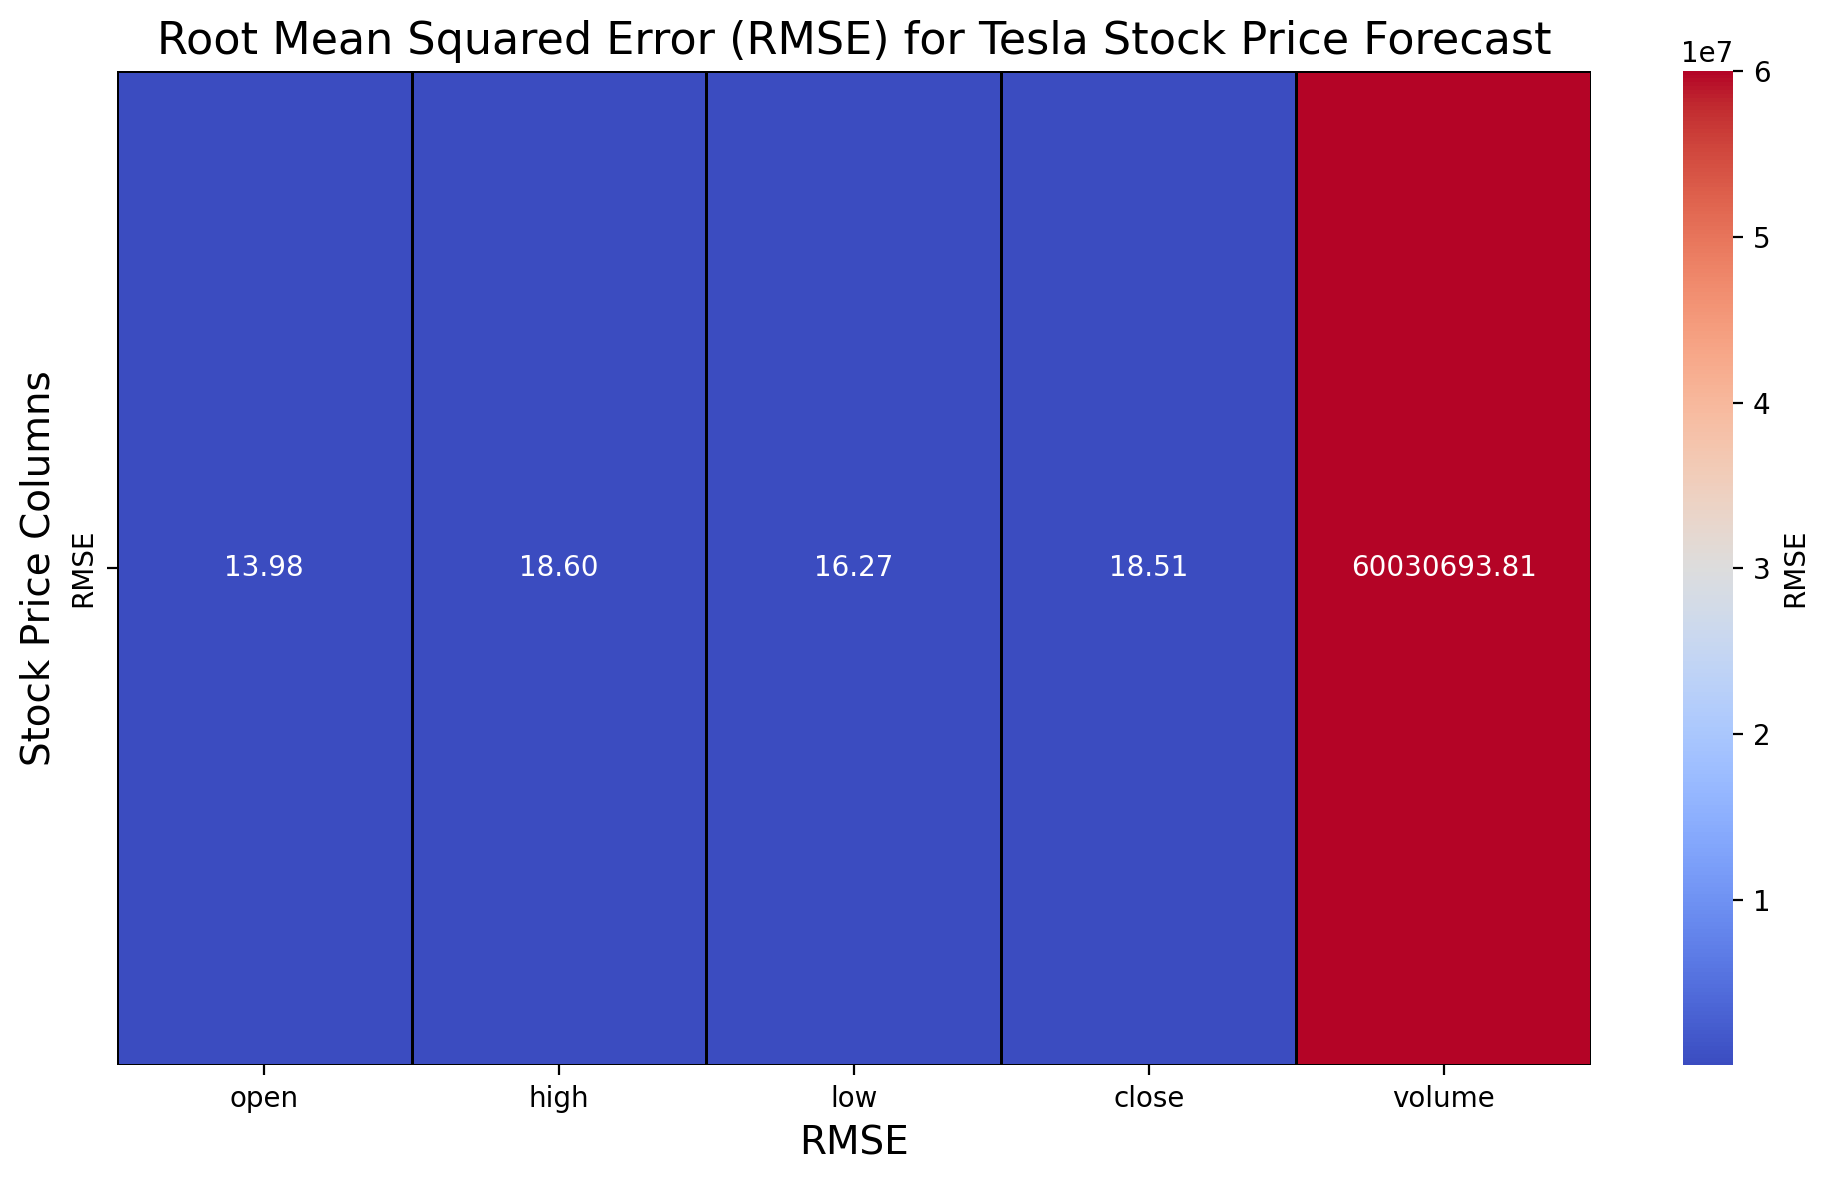

In [82]:
import pandas as pd
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

# Load model with the best weights
ms_model = load_model('Multi_LSTM_Tesla_best_model.keras')

# Get data for testing
data_to_test = df[columns].iloc[-n_steps_in:]

# Showing data shape for verification
print(f'Test Data Shape: {data_to_test.shape}')
# Assuming 'show' is a custom function, replace with display or print if needed
display(data_to_test.tail())

# Forecast using the model
forecast = ms_rnn_formatter.multi_step_forecast(ms_model, data_to_test.values)

# Set the forecast index to correspond to the forecast period (assuming business days)
forecast.index = pd.date_range(start=end_date, periods=n_steps_out, freq='B')
print(f'Forecast shape: {forecast.shape}')
display(forecast)

# Assuming df_test contains the true future values to compare
# Calculate error: forecasted values minus actual future values from df_test
error_array = forecast.values - df_test[columns].values

# Make a dataframe of errors (difference between forecast and actual values)
errors = pd.DataFrame(error_array, index=df_test.index, columns=[f'error_{col}' for col in columns])

# Calculate RMSE (Root Mean Squared Error) for each column
rmse_per_column = np.sqrt(np.mean(error_array**2, axis=0))

# Create a DataFrame to display RMSE for each column
root_mean_squared_error = pd.DataFrame(rmse_per_column, columns=['RMSE'], index=columns)

# Customize table display style
styled_table = root_mean_squared_error.style.background_gradient(cmap='YlGnBu') \
    .set_table_styles([{'selector': 'thead th', 'props': [('background-color', '#4CAF50'), ('color', 'white')]},
                       {'selector': 'tbody td', 'props': [('font-size', '14px'), ('text-align', 'center')]},
                       {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}])

# Display the styled table
display(styled_table)

# Customize display colors using Seaborn for RMSE Heatmap
plt.figure(figsize=(10, 6))

# Use a different color palette for a more aesthetic heatmap
sns.heatmap(root_mean_squared_error.T, annot=True, cmap="coolwarm", cbar_kws={'label': 'RMSE'}, fmt='.2f',
            linewidths=0.5, linecolor='black', cbar=True)

# Set better labels and a more refined title
plt.title('Root Mean Squared Error (RMSE) for Tesla Stock Price Forecast', fontsize=16)
plt.ylabel('Stock Price Columns', fontsize=14)
plt.xlabel('RMSE', fontsize=14)

# Display the heatmap with improved styling
plt.tight_layout()
plt.show()


In [83]:
# You already have this
data_to_test = df[columns].iloc[-n_steps_in:]

# Load model
ms_model = models.load_model('Multi_LSTM_Tesla_best_model.keras')

# Predict using the model
forecast = ms_rnn_formatter.multi_step_forecast(ms_model, data_to_test.values)

# Align forecast index
forecast.index = pd.date_range(start=end_date, periods=n_steps_out, freq=BDay())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


In [84]:
# Assuming df_test holds the true future values to compare
error_array = forecast.values - df_test[columns].values

# Make a dataframe of errors
errors = pd.DataFrame(error_array, index=df_test.index, columns=[f'error_{col}' for col in columns])


In [85]:
import pandas as pd

# Turn into a proper table
root_mean_squared_error = pd.DataFrame(rmse_per_column, columns=['RMSE New TLSA Data'])

# Show transpose view (optional)
show(root_mean_squared_error.T)


,0,1,2,3,4
RMSE New TLSA Data,13.982,18.598,16.274,18.512,60030693.811


<a name='B'>
       
<div style="padding: 15px; color: white; font-size: 250%; font-family: Tahoma; text-align: center; display:fill; border-radius: 50px; background-color: cyan; margin-bottom: 0px;"><b><span style='color: white'> Thanks </b></div>
    
    
## &#8711; <span style='color:red'>|</span> Table of Contents
1. [`Introduction`](#I)
2. [`Tesla Data`](#D)
3. [`Imports & Setup`](#is)
    * 3.1 [`Tesla Data`](#tsladata)
4. [`Data Visualization`](#DV)
    * 4.1 [`Candlestick Plots`](#DV)
    * 4.2 [`Stock Splits`](#splits)
    * 4.3 [`Percentage Change in Stock`](#pchange)
5. [`Single Step LSTM`](#lstm)
    * 5.1 [`Data Prep`](#lstm)
    * 5.2 [`Model Building`](#buildmodel)
    * 5.3 [`Predictions`](#pred)
6. [`Multi-Step Stacked LSTM`](#mlstm)
    * 6.1 [`Multi-Step Math Background`](#mlstm)
    * 6.2 [`Stacked LSTM Background`](#background)
    * 6.3 [`Multi-Step Data Prep`](#mutlidataprep)
    * 6.4 [`Buidling Stacked LSTM`](#buildmlstm)
    * 6.5 [`Forecasting Multi-Step Stacked LSTM`](#forecast)
7. [`Top`](#T)

